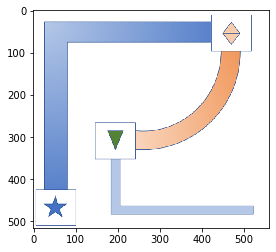

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
frame = cv2.imread("Picture1.png")
imshow(frame)

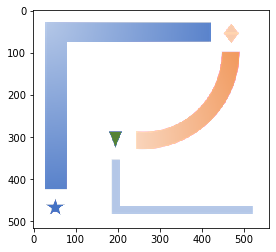

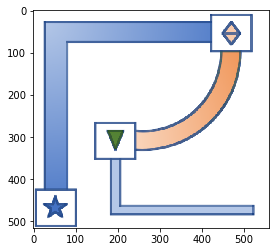

In [2]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
LUV = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(frame,kernel,iterations = 1)
erosion = cv2.erode(frame,kernel,iterations = 1)
imshow(dilation)
imshow(erosion)

In [3]:
def is_contour_rect(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return len(approx) == 4
def is_contour_square(c):
    if not is_contour_rect(c): return False    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    area = cv2.contourArea(approx)
    if area == 0: return False
    rect = cv2.boundingRect(approx)
    s_area = rect[2] * rect[3]
    return s_area/area > 0.9 and area/s_area > 0.9
def filter_contour_square(cnts):
    buffer = []
    for i, c in enumerate(cnts):
        if is_contour_square(c): buffer.append(np.array(c, dtype=np.int32))
    return buffer

Found 3 card.


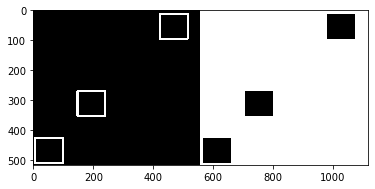

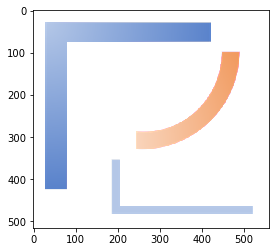

Found 3 path.


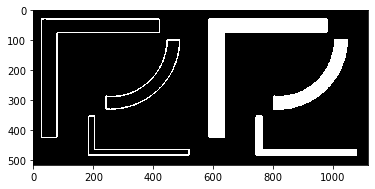

In [4]:
edges = cv2.Canny(dilation, 20, 100)
edges_luv = cv2.Canny(LUV, 20, 100)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours_luv, hierarchy_luv = cv2.findContours(edges_luv,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize card border
marker_mask = np.ones(frame.shape[:2], dtype="uint8") * 255 # For exclude marker
contour_square = filter_contour_square(contours_luv) # Filter only card (square)
print("Found {} card.".format(len(contour_square)))
cv2.drawContours(marker_mask, contour_square, -1, 0, -1)
for i in range(len(contour_square)): # Draw contour of each card
    cv2.drawContours(black, contour_square, i, 255, 6)
imshow(np.hstack((black, marker_mask)))

## Remove marker and fill with white
path_img = cv2.bitwise_and(dilation, dilation, mask=marker_mask)
path_img = cv2.fillPoly(path_img, contour_square, (255, 255, 255))
imshow(path_img)

## Find contour of path
edges_path = cv2.Canny(path_img, 20, 100)
contours_path, hierarchy_path = cv2.findContours(edges_path,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Found {} path.".format(len(contours_path)))

## Making path mask
black = np.zeros(frame.shape[:2], dtype="uint8")
cv2.drawContours(black, contours_path, -1, 255, 3)
path_mask = np.zeros(frame.shape[:2], dtype="uint8") # For visualize
path_mask = cv2.fillPoly(black.copy(), contours_path, 255)
imshow(np.hstack((black, path_mask)))

In [5]:
class Card:
    def __init__(self, contours):
        self.contours = contours
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        self.rect = np.asarray(approx, dtype = "float32")
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        self.center = (cX, cY)
    def image(self, source):
        maxWidth, maxHeight = 50, 50
        dst = np.array([[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")
        M = cv2.getPerspectiveTransform(self.rect, dst)
        warped = cv2.warpPerspective(source, M, (maxWidth, maxHeight))
        return warped
class Path:
    def __init__(self, contours):
        self.contours = contours
        

[(53, 467), (194, 309), (469, 54)]


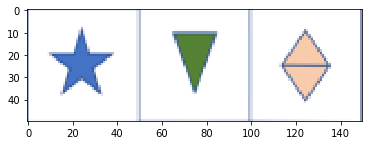

In [6]:
Cards = []
for c in contour_square: # Loop each card contour
    Cards.append(Card(c))
print([x.center for x in Cards])
imshow(np.hstack(tuple([x.image(frame) for x in Cards])))

Paths = []
for c in contours_path: # Loop each path contour
    Paths.append(Path(c))



Got Start Marker!


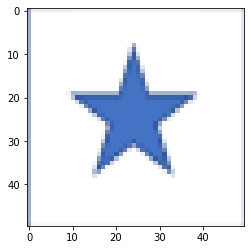

In [7]:
def cartesian_distance(x, y): return math.sqrt(x**2+y**2)
## Locate first Marker
def first_card(markers, source):
    (h, w) = source.shape[:2]
    centers = [marker.center for marker in markers]
    ## Find distance from corner
    distances = []
    for center in centers:
        dis_x = min(center[0], w-center[0])
        dis_y = min(center[1], h-center[1])
        distances.append(cartesian_distance(dis_x, dis_y))
    index_start = np.argmin(distances) # return index of minimum distance
    return markers[index_start]
start_card = first_card(Cards, frame)
print("Got Start Marker!")
imshow(start_card.image(frame))

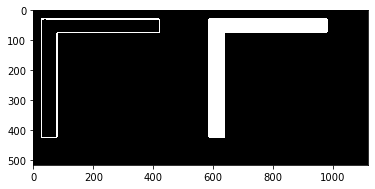

In [8]:
## Find distance from marker to each contours of path (outside distance will seen as negative distance)
dis_start = [cv2.pointPolygonTest(contours, start_card.center, True) for contours in contours_path]
dis_start = [abs(x) for x in dis_start]
index_start_path = np.argmin(dis_start)

black = np.zeros(frame.shape[:2], dtype="uint8")
cv2.drawContours(black, [contours_path[index_start_path]], -1, 255, 3)
path_mask = np.zeros(frame.shape[:2], dtype="uint8") # For visualize
path_mask = cv2.fillPoly(black.copy(), [contours_path[index_start_path]], 255)
imshow(np.hstack((black, path_mask)))

In [18]:
def minDistance(contour1, contour2):
    distanceMin = 99999999
    for xA, yA in contour1[0]:
        for xB, yB in contour2[0]:
            distance = ((xB-xA)**2+(yB-yA)**2)**(1/2) # distance formula
            if (distance < distanceMin):
                distanceMin = distance
    return distanceMin

def sort_path(markers, contours_path):
    used_markers, used_paths = [], []
    while True:
        if len(used_markers) == len(Cards) and len(used_paths) == len(Paths): break

193.31321734428818
